# <center> Анализ вакансий ручных тестировщиков<center>

###  Цель проекта

- Выбрать и проанализировать вакансии, на которые студенты QA факультета могут откликнуться и получить приглашение на интервью.
- Оценить объем рынка вакансий для начинающих тестировщиков.

### Задачи проекта

**Исследовательский анализ вакансий**

1. Портрет вакансии самые частые требования и задачи выделить наиболее популярные сегменты / группы вакансий 
    
2.  Анализ креативности вакансий. Как вакансии изменялись со временем? 

**Вопросы от заказчика**

1. Емкость рынка по годам.

2. Емкость рынка по регионам и по годам.
    
3. Доля вакансий, в которой упоминается «исследовательское тестирование» 

4. Распределение по регионам и количество вакансий с удаленной работой. 
    
5. Распределение по регионам и количество компаний, которые размещают вакансии на удаленку (вне зависимости от региона, в котором вакансия размещается)
    
6. Аналогично п. 4 и 5, только про частичную занятость, а не удаленку

7. Существуют ли сезонные пики и спады в распределении числа активных вакансий в течение года и если да — существуют везде или, например, в Москве спадов нет? 

8. Сколько вакансий-стажировок (с дополнительным к основной выборке словом «стажер»/«стажёр»/«стажировка» в названии) и их распределение по регионам
   
9. Сколько вакансий джунов называются «тестировщик», «QA» или «QC»? Не случился ли перекос в сторону наименования QA?


### 1. Изучение и предобработка данных

In [1]:
import pandas as pd
import numpy as np
import datetime
import re
from datetime import datetime, date
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from pymystem3 import Mystem
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
import operator

pd.set_option('display.max_columns',20)
pd.set_option('display.max_rows',20)

fig_width = 9
fig_height = 4


In [2]:
job_data = pd.read_csv("jobs.csv", sep='|')
job_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680561 entries, 0 to 680560
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Unnamed: 0            680561 non-null  int64 
 1   vacancy_id            680561 non-null  int64 
 2   vacancy_name          680561 non-null  object
 3   vacancy_description   680561 non-null  object
 4   experience_required   680561 non-null  object
 5   type_of_employment    680561 non-null  object
 6   work_schedule         680561 non-null  object
 7   publication_day       680561 non-null  object
 8   city_name             680561 non-null  object
 9   region_name           610122 non-null  object
 10  country_name          680561 non-null  object
 11  list_of_profarea_ids  680561 non-null  object
 12  list_of_skill_names   680561 non-null  object
dtypes: int64(2), object(11)
memory usage: 67.5+ MB


In [3]:
job_data_nice = job_data.copy()
#удалим первый столбец
del job_data_nice['Unnamed: 0']
#del job_data_nice['level_0']
#del job_data_nice['index']
job_data_nice = job_data_nice.reset_index()
#приведение к нижнему регистру
job_data_nice['vacancy_name'] = job_data_nice['vacancy_name'].str.lower()
#форматируем дату публикации
job_data_nice["publication_day"] = pd.to_datetime(job_data_nice["publication_day"],format="%Y-%m-%dT%H:%M:%S")


In [4]:
#Убедимся, что данные в столбце no_experience корректны и выберем только объявления без опыта работы
print(job_data_nice['experience_required'].value_counts())
job_data_nice = job_data_nice[job_data_nice['experience_required'] == 'no_experience']

job_qa = (job_data_nice.query('vacancy_name.str.contains("qa|test|тестир|quality|quality&assurance|qc")', engine='python')
                       .reset_index())
#добавим необходимые столбцы
job_qa['year_publication'] = job_qa['publication_day'].dt.year
job_qa['month_publication'] = job_qa['publication_day'].dt.month

display(job_qa.head(5))


up_to_3_years    362514
up_to_6_years    182414
no_experience    116956
above_6_years     18677
Name: experience_required, dtype: int64


,level_0,index,vacancy_id,vacancy_name,vacancy_description,experience_required,type_of_employment,work_schedule,publication_day,city_name,region_name,country_name,list_of_profarea_ids,list_of_skill_names,year_publication,month_publication
0,14,14,23920048,тестировщик по,<p><strong>Обязанности:</strong></p> <p>- Тест...,no_experience,full,full_day,2017-12-25,Москва,Москва,Россия,1,[None],2017,12
1,315,315,22728748,тестировщик мморпг,<p><strong>Friday’s Games</strong> – студия-ра...,no_experience,full,full_day,2017-09-14,Новосибирск,Новосибирская область,Россия,1,[None],2017,9
2,544,544,20288758,qa specialist (автоматизированное тестирование),<p><strong>Если ты хочешь развиваться в автома...,no_experience,full,full_day,2017-04-18,Москва,Москва,Россия,1,[None],2017,4
3,1124,1124,19734864,тестировщик по,<p><strong>Обязанности:</strong></p> <ul> <li>...,no_experience,full,full_day,2017-03-30,Москва,Москва,Россия,1,[None],2017,3
4,1404,1404,21895263,junior tester,<p>В крупном иностранном Банке открыта позиция...,no_experience,full,full_day,2017-09-04,Москва,Москва,Россия,1,[None],2017,9


#### Вывод:
Принято решение взять срез данных только "без опыта работы" с разными вариациями "тестировщика", как подбор вакансий нацелен на аудиторию студентов QA факультета.

### 2.Анализ данных

##### Портрет вакансии самые частые требования и задачи выделить наиболее популярные сегменты / группы вакансий

In [5]:
#Склеить словосочетания из кортежей вида (('в', 'операционной', 'системе'), 5.169925001442312)
#список строк
def collocs_to_list(collocs):
    res = []
    for c in collocs:
        lst_words = list(c[0])
        res.append(' '.join(lst_words))
    return res
 
#построить тройные словосочетания из списка слов
def get_trigrams(words):
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    finder = nltk.collocations.TrigramCollocationFinder.from_words(words)
    return collocs_to_list(finder.score_ngrams(trigram_measures.pmi))

#построить двойные словосочетания из списка слов
def get_bigrams(words):
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = nltk.collocations.BigramCollocationFinder.from_words(words)
    return collocs_to_list(finder.score_ngrams(bigram_measures.pmi))

#Построить список возможных словосочетаний из предложения
def my_tokenize(text):
    #убрать все символы кроме слов
    text = re.sub(r'[^\w]', ' ', text)
    #разделить строку на список токенизированных слов
    words = word_tokenize(text)
    #return get_bigrams(words) + get_trigrams(words)
    return get_trigrams(words)

def count_phrases(text, phrases):
    phrases_lst = my_tokenize(text)
    for ph in phrases_lst:
        if ph in phrases:
            phrases[ph] = phrases[ph] + 1
        else:
            phrases[ph] = 1
                    
def extract_reqs(description, phrases):
    soup=BeautifulSoup(description.lower(), 'lxml')
    for tag in soup.recursiveChildGenerator():
        if tag.name:
            if not tag.find():
                if (('знание' in tag.text) or 
                    ('понимание' in tag.text) or 
                    ('образование' in tag.text) or 
                    ('умение' in tag.text) or 
                    ('наличие' in tag.text) or 
                    ('опыт' in tag.text)):
                    count_phrases(tag.text, phrases)

def extract_duties(description, phrases):
    soup=BeautifulSoup(description.lower(), 'lxml')
    for tag in soup.recursiveChildGenerator():
        if tag.name:
            if not tag.find():
                if (('проектирование' in tag.text) or 
                    ('анализ' in tag.text) or 
                    ('сопровождение' in tag.text) or 
                    ('проведение' in tag.text) or 
                    ('участие' in tag.text) or 
                    ('оказание' in tag.text) or 
                    ('изучение' in tag.text) or 
                    ('тестирование' in tag.text) or 
                    ('написание' in tag.text) or 
                    ('разработка' in tag.text) or 
                    ('написание' in tag.text)):
                    count_phrases(tag.text, phrases)
                    
req_dict = {}
duty_dict = {}
for i in range(0,job_qa['vacancy_description'].count()):
    extract_reqs(job_qa.iloc[i]['vacancy_description'], req_dict)
    extract_duties(job_qa.iloc[i]['vacancy_description'], duty_dict)

In [6]:
def print_dict(dic, limit, min_count):
    dic_sorted = dict(sorted(dic.items(), key=operator.itemgetter(1),reverse=True))
    lim = limit if limit < len(dic_sorted) else len(dic_sorted)
    for key in dic_sorted:
        lim = lim - 1
        if lim < 0:
            break
        if dic_sorted[key] < min_count:
            break
        print(key,'-',dic_sorted[key])

print_dict(req_dict, 70, 20)

опыт работы с - 1048
опыт работы в - 421
высшее техническое образование - 336
умение работать в - 292
работать в команде - 282
работы с системами - 188
знание английского языка - 167
опыт ручного тестирования - 135
умение работать с - 119
понимание принципов работы - 118
sql на уровне - 105
ручного тестирования сервисов - 98
сервисов и приложений - 98
тестирования сервисов и - 98
выполнять задания на - 98
готовность выполнять задания - 98
задания на них - 98
наличие собственного мобильного - 98
собственного мобильного устройства - 98
и готовность выполнять - 98
компьютера и готовность - 98
мобильного устройства и - 98
устройства и компьютера - 98
и компьютера и - 98
быстрого интернет канала - 98
и быстрого интернет - 98
надежного и быстрого - 98
наличие надежного и - 98
английского языка на - 87
знание sql на - 86
работы в тестировании - 83
на уровне написания - 81
опыт автоматизации тестирования - 80
на уровне чтения - 74
знание теории тестирования - 72
языка на уровне - 71
опыт работ

In [7]:
print_dict(duty_dict, 50, 10)

написание тест кейсов - 124
тестирование новых возможностей - 106
по готовым сценариям - 104
написание сценариев для - 100
сценариев для тестирования - 99
продуктов по готовым - 98
разных продуктов по - 98
регрессионное тестирование разных - 98
тестирование разных продуктов - 98
исследовательское тестирование новых - 98
тестирование программного обеспечения - 92
разработка тест кейсов - 86
анализ результатов тестирования - 84
проведение ручного тестирования - 75
разработка и поддержка - 70
разработка тестовых сценариев - 60
ручное функциональное тестирование - 59
разработка тестовой документации - 58
тест кейсов и - 54
участие в разработке - 52
участие в проектах - 47
разработка сценариев тестирования - 47
и мобильных приложений - 45
принять участие в - 45
в актуальном состоянии - 43
и анализ результатов - 39
и тест кейсов - 37
ручное и автоматизированное - 35
изучение английского языка - 34
и автоматизированное тестирование - 33
тестирование мобильных приложений - 32
проведение функци

In [8]:
vacancy_dict = {}
for i in range(0,job_qa['vacancy_name'].count()):
    count_phrases(job_qa.iloc[i]['vacancy_name'], vacancy_dict)
        
print_dict(vacancy_dict, 50, 10)

специалист по тестированию - 298
инженер по тестированию - 175
по тестированию по - 162
junior qa engineer - 160
тестировщик программного обеспечения - 60
qa automation engineer - 56
по нагрузочному тестированию - 55
младший инженер по - 54
qa специалист тестировщик - 48
по автоматизированному тестированию - 48
младший специалист по - 45
младший тестировщик по - 34
тестировщик по qa - 32
qa engineer тестировщик - 30
специалист тестировщик игр - 30
инженер по автоматизированному - 28
инженер по нагрузочному - 28
по qa engineer - 26
qa инженер тестировщик - 23
тестировщик по junior - 21
по тестированию junior - 21
тестировщик мобильных приложений - 21
тестировщик qa engineer - 21
по автоматизации тестирования - 20
стажер по нагрузочному - 19
по тестированию qa - 19
по junior qa - 18
junior qa automation - 18
тестировщик задач по - 17
в отдел тестирования - 17
специалист по автоматизированному - 16
стажер в отдел - 16
инженер по автоматизации - 16
engineer тестировщик по - 15
стажер тести

#### Вывод:

Самые частые требования к вакансии тестировщик это:

- высшее/неоконченное высшее техническое образование
- знание английского языка
- опыт ручного тестирования сервисов и/или приложений
- знание SQL
- наличие собственного компьютера и/или мобильного устройства
- наличие быстрого интернет канала
- опыт автоматизации тестирования 
- знание теории тестирования
- знакомство с системами контроля версий
- знание основ программирования
- опыт тестирования web приложений
- умение четко выражать свои мысли
- опыт работы с баг-трекерами

Самые частые обязанности тестировщика это:

- написание тест кейсов и тестовых сценариев
- тестирование по готовым сценариям
- регрессионное и функциональное тестирование разных продуктов
- исследовательское тестирование новых продуктов
- анализ результатов тестирования 
- проведение ручного тестирования 
- автоматизированное тестирование
- разработка тестовой документации 
- тестирование мобильных приложений 
- тестирование web приложений 
- разработка методик тестирования

Среди вакансий можно выделить следующие группы:

 - специалист по ручному и/или автоматизированному тестированию
 - тестировщик мобильных приложений
 - тестировщик web-приложений
 - тестировщик игр

##### Анализ креативности вакансий. Как вакансии изменялись со временем?

In [9]:
def find_words_year(wlist, year):
    wl = '|'.join(wlist)
    return job_qa.query('vacancy_description.str.contains("' + wl + '") and (year_publication == ' + str(year) + ')', engine='python')

words = ['клев','крут','плюшк','печеньк','бонус']
print('Креативные объявления по годам:')
print('2017:',find_words_year(words, 2017).shape[0])
print('2018:',find_words_year(words, 2018).shape[0])
print('2019:',find_words_year(words, 2019).shape[0])

Креативные объявления по годам:
2017: 129
2018: 153
2019: 238


Количество креативных объявлений заметно растет с каждым годом.

##### Емкость рынка по годам.

In [10]:
job_year_tab =job_qa.groupby('year_publication').agg({'publication_day': 'count'}).reset_index() 
job_year_tab.columns = ['year_publication','count_publications']
job_year_tab

,year_publication,count_publications
0,2017,900
1,2018,920
2,2019,1041


In [11]:
part_2018 = ((job_year_tab['count_publications'][1]-job_year_tab['count_publications'][0])
                    /job_year_tab['count_publications'][0])

part_2019 = ((job_year_tab['count_publications'][2]-job_year_tab['count_publications'][1])
                    /job_year_tab['count_publications'][1])

print('Увеличение спроса на вакансию тестировщик в 2018 по сравнению с 2017 на {:.1%}'.format(part_2018))
print('Увеличение спроса на вакансию тестировщик в 2019 по сравнению с 2018 на {:.1%}'.format(part_2019))

Увеличение спроса на вакансию тестировщик в 2018 по сравнению с 2017 на 2.2%
Увеличение спроса на вакансию тестировщик в 2019 по сравнению с 2018 на 13.2%


#### Вывод:
Заметна динамика увелечения спроса на вакансию тестировщик.

##### Емкость рынка по регионам и по годам.

In [12]:
job_region_year_tab = (job_qa
        .pivot_table(index = 'region_name',columns = 'year_publication', values = 'publication_day',aggfunc='count'))
display(job_region_year_tab)

year_publication,2017,2018,2019
region_name,,,
Алтайский край,13.0,6.0,7.0
Амурская область,1.0,2.0,2.0
Архангельская область,NaN,1.0,1.0
Астраханская область,NaN,5.0,1.0
Белгородская область,8.0,9.0,6.0
...,...,...,...
Ханты-Мансийский АО - Югра,NaN,NaN,1.0
Челябинская область,7.0,9.0,13.0
Чеченская республика,NaN,NaN,1.0


In [13]:
job_region_year_tab['total'] = job_region_year_tab[2017]+job_region_year_tab[2018]+job_region_year_tab[2019]
display(job_region_year_tab.sort_values(by='total',ascending=False).head(10))

year_publication,2017,2018,2019,total
region_name,,,,
Москва,209.0,225.0,276.0,710.0
Санкт-Петербург,75.0,98.0,123.0,296.0
Новосибирская область,63.0,61.0,37.0,161.0
Нижегородская область,21.0,30.0,29.0,80.0
Свердловская область,19.0,28.0,33.0,80.0
Республика Татарстан,22.0,21.0,36.0,79.0
Ростовская область,30.0,22.0,27.0,79.0
Самарская область,30.0,21.0,14.0,65.0
Воронежская область,17.0,24.0,21.0,62.0


#### Вывод:
В Москве и Санкт-Петербурге, которые являются лидерами по количеству предложений вакансий, в разбивке по регионам и годам наблюдается тенденция роста спроса на тестировщиков. В остальных регионах четкой картины нет.

##### Соотношение между видами рабочего расписания

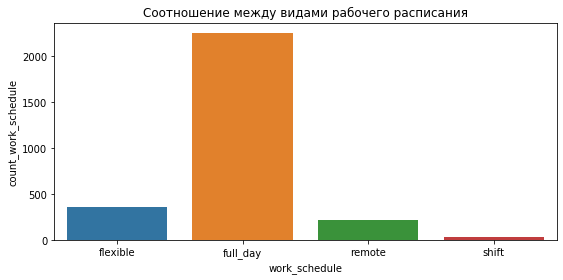

In [14]:
job_work_schedule = job_qa.groupby('work_schedule').agg({'vacancy_id': 'count'}).reset_index()
job_work_schedule.columns = ['work_schedule','count_work_schedule']
values= job_work_schedule['count_work_schedule']
labels = job_work_schedule['work_schedule']

plt.figure(figsize=(fig_width, fig_height))
sns.barplot(data=job_work_schedule, x=labels, y=values)
plt.title("Соотношение между видами рабочего расписания")
plt.show()


#### Вывод:
Полный рабочий день явно превалирует в видах рабочего расписания.

##### Соотношение типа занятости.

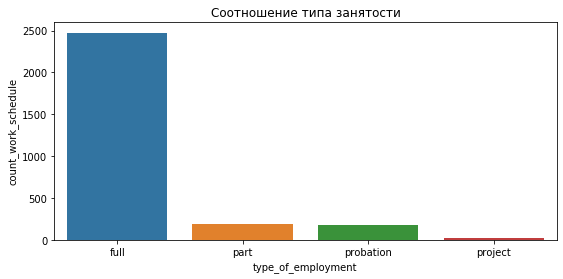

In [15]:
job_work_schedule = job_qa.groupby('type_of_employment').agg({'vacancy_id': 'count'}).reset_index()
job_work_schedule.columns = ['type_of_employment','count_work_schedule']
values= job_work_schedule['count_work_schedule']
labels = job_work_schedule['type_of_employment']

plt.figure(figsize=(fig_width, fig_height))
sns.barplot(data=job_work_schedule, x=labels, y=values)
plt.title("Соотношение типа занятости")
plt.show()

#### Вывод:
Полная занятость явно доминирует.

##### Доля вакансий, в которой упоминается «исследовательское тестирование» 

In [16]:
job_research = (job_qa[job_qa['vacancy_description']
                 .str.contains('исследовательск') & job_qa['vacancy_description'].str.contains('тестир')])
print('Доля вакансий, в которой упоминается «исследовательское тестирование»: {:.2%}'.format(len(job_research)/len(job_qa)))

Доля вакансий, в которой упоминается «исследовательское тестирование»: 4.82%


##### Распределение вакансий с удаленной работой по регионам. 

In [17]:
job_region_remote = (job_qa[job_qa['work_schedule']=='remote']
                               .groupby('region_name')
                               .agg({'vacancy_id': 'count'})
                               .rename(columns = {'vacancy_id': 'count_remote'}))

job_region = (job_qa
                               .groupby('region_name')
                               .agg({'vacancy_id': 'count'})
                               .rename(columns = {'vacancy_id': 'count_total'}))

job_region_remote['relative'] = job_region_remote['count_remote'] / job_region['count_total']

display(job_region_remote[job_region_remote['count_remote'] > 5].sort_values(by='relative', ascending=False)
                                                           .style.format({'relative': '{:.1%}'}))
    


,count_remote,relative
region_name,,
Иркутская область,6,60.0%
Кемеровская область,6,54.5%
Красноярский край,6,35.3%
Челябинская область,9,31.0%
Московская область,8,27.6%
Пермский край,6,17.6%
Саратовская область,6,17.1%
Омская область,6,13.6%
Самарская область,7,10.8%


#### Вывод:
При рассмотрении данного показателя стоит вычислить долю (процент) вакансий с возможностью работать удаленно от общего числа вакансий. При этом можно отбросить регионы с общим количеством удаленных вакансий менее 5 (за 3 года), т.к. эти данные не представлют собой статистической значимости.

Среди оставшихся регионов просматривается тенденция, говорящая о том, что в крупных городах отдают предпочтение работе в офисе. Для Москвы доля таких вакансий всего 3.2%, для СПб - 2.4%.

##### Распределение вакансий с частичной занятостью по регионам.

In [18]:
job_region_partial = (job_qa[job_qa['type_of_employment']=='part']
                               .groupby('region_name')
                               .agg({'vacancy_id': 'count'})
                               .rename(columns = {'vacancy_id': 'count_remote'}))

job_region_partial['relative'] = job_region_partial['count_remote'] / job_region['count_total']
display(job_region_partial[job_region_partial['count_remote'] > 5]
                                 .sort_values(by='relative', ascending=False)
                                 .style.format({'relative': '{:.1%}'}))


,count_remote,relative
region_name,,
Московская область,9,31.0%
Саратовская область,6,17.1%
Самарская область,8,12.3%
Республика Татарстан,8,10.1%
Нижегородская область,7,8.8%
Санкт-Петербург,18,6.1%
Москва,21,3.0%


#### Вывод:

Аналогичная ситуация наблюдается и с частичной занятостью. В крупных городах доля вакансий с частичной занятостью не велика - Москва 3%, СПб - 6.1%. Однако, в Московской области доля таких вакансий достигает 31%. 

##### Существуют ли сезонные пики и спады в распределении числа активных вакансий в течение года и если да — существуют везде или, например, в Москве спадов нет? 

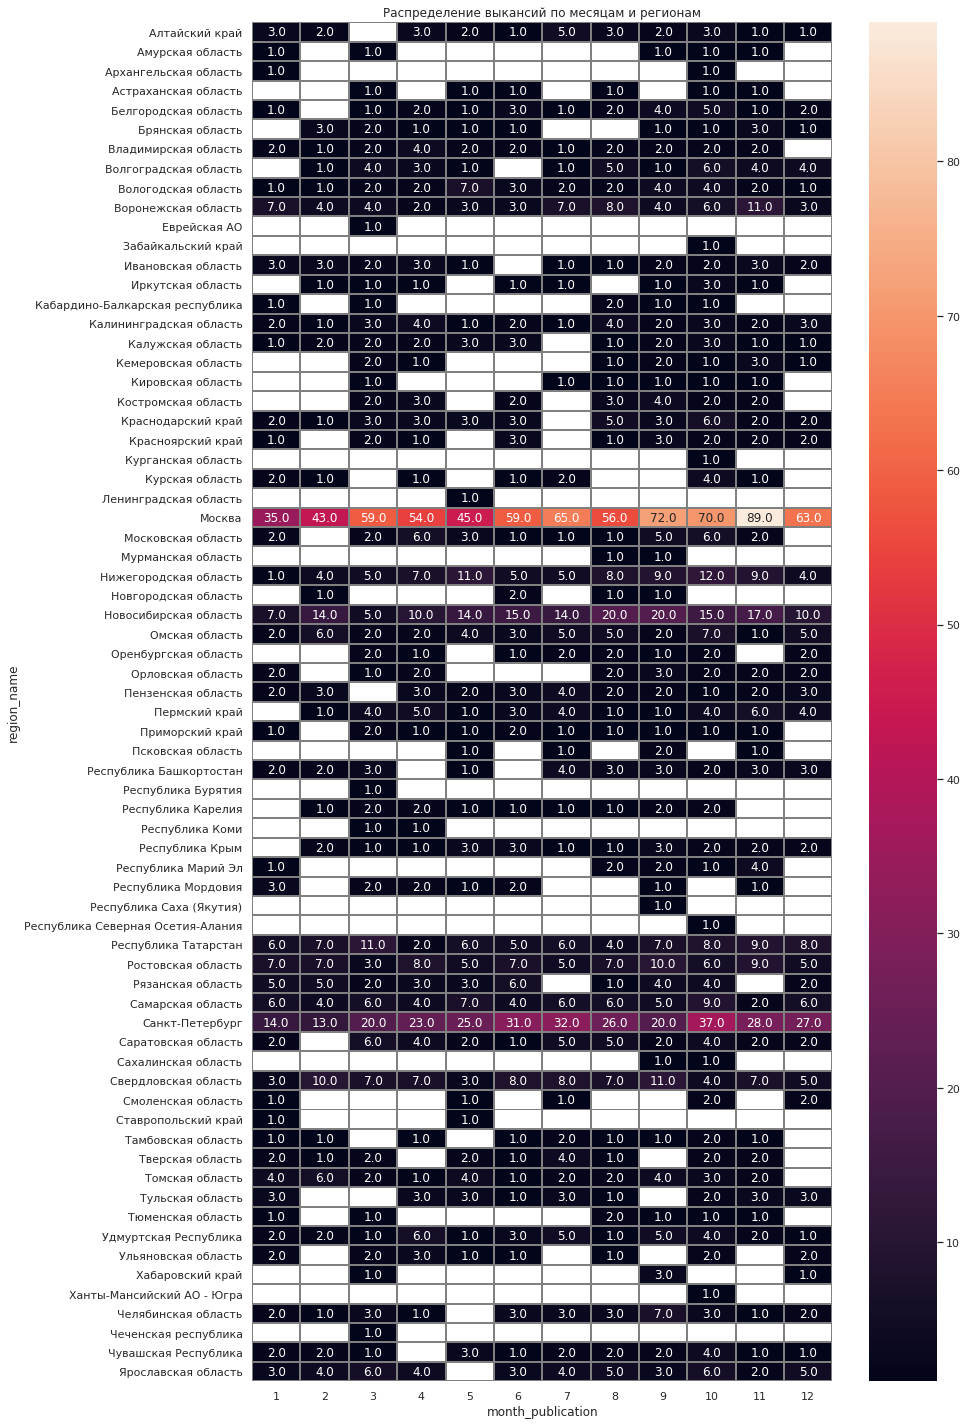

In [19]:
job_region_month_tab = (job_qa
        .pivot_table(index = 'region_name',columns = 'month_publication', values = 'publication_day',aggfunc='count')
        )

sns.set(style='white')
plt.figure(figsize=(13, 25))
plt.title('Распределение выкансий по месяцам и регионам')
sns.heatmap(job_region_month_tab, annot=True, fmt='.1f', linewidths=1, linecolor='gray')

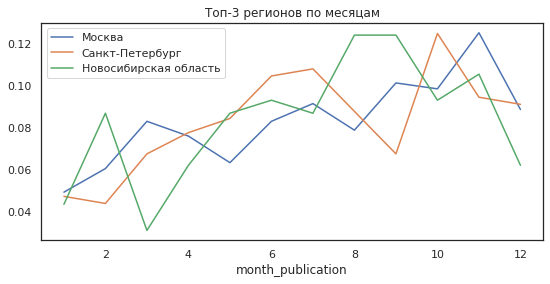

In [20]:
job_region_month_tab_rel = job_region_month_tab.copy()
job_region_month_tab_rel.loc[:,'Total'] = job_region_month_tab_rel.sum(axis=1) 
job_region_month_tab_rel = job_region_month_tab_rel.sort_values(by='Total', ascending=False)
job_region_month_tab_rel.iloc[:,0:12] = (job_region_month_tab_rel.iloc[:,0:12]
                                         .div(job_region_month_tab_rel.iloc[:,12], axis=0))
del job_region_month_tab_rel['Total']

plt.figure(figsize=(fig_width, fig_height))
job_region_month_tab_rel.loc['Москва'].plot(label='Москва', legend=True)
job_region_month_tab_rel.loc['Санкт-Петербург'].plot(label='Санкт-Петербург', legend=True)
job_region_month_tab_rel.loc['Новосибирская область'].plot(label='Новосибирская область', legend=True)
plt.title('Топ-3 регионов по месяцам')
plt.show()

In [21]:
job_region_month_year_tab = (job_qa
        .pivot_table(
            index = ['year_publication','month_publication'], 
            columns='region_name', 
            values = 'publication_day',
            aggfunc='count')
        .fillna(0)
        )

totals = job_region_month_year_tab.sum(axis = 0)
job_region_month_year_tab.iloc[:,:] = (job_region_month_year_tab.iloc[:,:]
                                         .div(totals.iloc[:], axis=1))
job_region_month_year_tab = job_region_month_year_tab.reset_index().fillna(0)

job_region_month_year_tab


region_name,year_publication,month_publication,Алтайский край,Амурская область,Архангельская область,Астраханская область,Белгородская область,Брянская область,Владимирская область,Волгоградская область,...,Тульская область,Тюменская область,Удмуртская Республика,Ульяновская область,Хабаровский край,Ханты-Мансийский АО - Югра,Челябинская область,Чеченская республика,Чувашская Республика,Ярославская область
0,2017,1,0.038462,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.090909,0.142857,0.030303,0.142857,0.0,0.0,0.034483,0.0,0.047619,0.022222
1,2017,2,0.038462,0.0,0.0,0.000000,0.000000,0.071429,0.045455,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.044444
2,2017,3,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.045455,0.033333,...,0.000000,0.142857,0.000000,0.071429,0.0,0.0,0.034483,0.0,0.000000,0.044444
3,2017,4,0.076923,0.0,0.0,0.000000,0.000000,0.000000,0.045455,0.033333,...,0.000000,0.000000,0.030303,0.142857,0.0,0.0,0.034483,0.0,0.000000,0.066667
4,2017,5,0.076923,0.0,0.0,0.000000,0.043478,0.000000,0.045455,0.000000,...,0.045455,0.000000,0.000000,0.071429,0.0,0.0,0.000000,0.0,0.047619,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,2019,8,0.038462,0.0,0.0,0.000000,0.000000,0.000000,0.045455,0.100000,...,0.045455,0.142857,0.000000,0.000000,0.0,0.0,0.068966,0.0,0.047619,0.022222
32,2019,9,0.076923,0.2,0.0,0.000000,0.043478,0.000000,0.000000,0.033333,...,0.000000,0.142857,0.090909,0.000000,0.4,0.0,0.137931,0.0,0.000000,0.044444
33,2019,10,0.038462,0.2,0.5,0.166667,0.086957,0.000000,0.045455,0.033333,...,0.000000,0.142857,0.030303,0.142857,0.0,1.0,0.068966,0.0,0.095238,0.000000
34,2019,11,0.000000,0.0,0.0,0.000000,0.043478,0.214286,0.045455,0.100000,...,0.045455,0.142857,0.000000,0.000000,0.0,0.0,0.034483,0.0,0.000000,0.000000


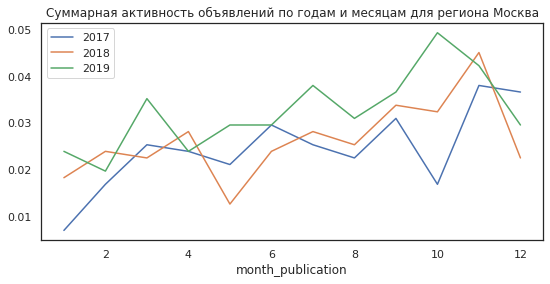

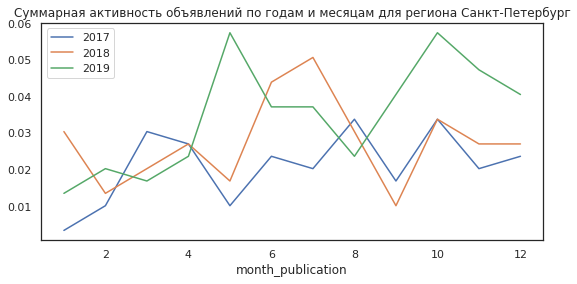

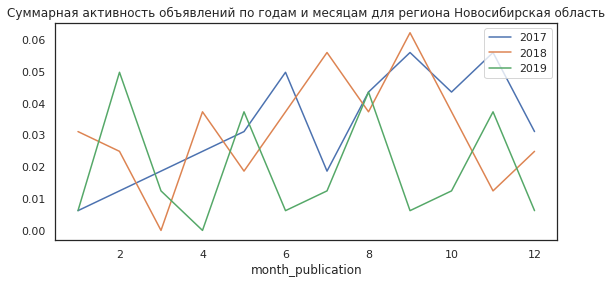

In [22]:
def region_graph(region):
    plt.figure(figsize=(fig_width, fig_height))
    for y in [2017,2018,2019]:
        (job_region_month_year_tab[job_region_month_year_tab['year_publication'] == y]
        .set_index('month_publication')
        [region]
        .plot(
            label=y, 
            legend=True,
        ))
#    sns.barplot(
#        data=job_region_month_year_tab,
#        x=job_region_month_year_tab['month_publication'],
#        y=job_region_month_year_tab[region],
#        hue=job_region_month_year_tab['year_publication']
#    )
    plt.title('Суммарная активность объявлений по годам и месяцам для региона ' + region)
    plt.show()
    
region_graph('Москва')
region_graph('Санкт-Петербург')
region_graph('Новосибирская область')


#### Вывод:

Большинство регионов не имеют достаточного количества вакансий ежемесячно, чтобы можно было сделать вывод о сезонности колебаний спроса на них. 

Поэтому, рассмотрев три самых больших по количеству вакансий региона, можно сказать следющее:

1) Для Москвы просматриваются сезонные колебания спроса. В начале года наблюдается низкая активность, потом постепенно количество объявлений увеличивается. Наибольшее количество объявлений заметно в сентябре и ноябре, а затем наблюдается предновогодний спад.

2) Для остальных регионов сезонной закономерности не просматривается.

##### Сколько вакансий-стажировок (с дополнительным к основной выборке словом «стажер»/«стажёр»/«стажировка» в названии) и их распределение по регионам?

In [23]:
job_qa_start = job_qa.query('vacancy_name.str.contains("стажер|стажёр|стажировк")', engine='python')
job_qa_start_region = (job_qa_start.groupby('region_name')
                               .agg({'vacancy_id': 'count'})
                               .sort_values(by='vacancy_id',ascending=False)
                               .rename(columns = {'vacancy_id': 'count_start'}))

job_qa_start_region['relative'] = job_qa_start_region['count_start'] / job_region['count_total']
display(job_qa_start_region[job_qa_start_region['count_start'] > 5]
                                             .sort_values(by='relative', ascending=False)
                                             .style.format({'relative': '{:.1%}'}))


,count_start,relative
region_name,,
Удмуртская Республика,10,30.3%
Рязанская область,10,28.6%
Воронежская область,15,24.2%
Нижегородская область,17,21.2%
Республика Татарстан,14,17.7%
Москва,111,15.6%
Санкт-Петербург,45,15.2%
Новосибирская область,10,6.2%


#### Вывод:

Вакансии-стажировки распределены по разным регионам. Но снова крупные центры разработки ПО (Москва, СПб, Новосибирск) не очень охотно нанимаются на работу стажеров. 

##### Сколько вакансий джунов называются «тестировщик», «QA» или «QC»? Не случился ли перекос в сторону наименования QA?

In [24]:
print("Тестировщиков:",job_qa.query('vacancy_name.str.contains("test|тестир")', engine='python')
                                                                                    ['experience_required'].count())
print("QA:", job_qa.query('vacancy_name.str.contains("qa|quality")', engine='python')
                                                                                    ['experience_required'].count())
print("QC:", job_qa.query('vacancy_name.str.contains("quality&assurance|qc")', engine='python')
                                                                                    ['experience_required'].count())
print("Total:", job_qa.query('vacancy_name.str.contains("qa|test|тестир|quality|quality&assurance|qc")', engine='python')
                                                                                   ['experience_required'].count())


Тестировщиков: 2360
QA: 898
QC: 12
Total: 2861


##### Вывод

Среди вакансий джунов перекос в сторону названия "тестировщик".

### Общий вывод и рекомендации

Если Вы начинающий тестировщик, желающий заниматься как ручным, так и автоматизированным тестированием в области мобильных приложений, web или игр - для Вас есть достаточное количество вакансий на НН, чтобы найти работу!

Более того, данное исследование рынка вакансий показало, что каждый год наблюдается увеличение спроса на тестировщиков. В 2018 спрос увеличился на 2.2%, а в 2019 - на 13.2%

Основной рынок труда, конечно, в Москве - там ежегодно публикуется порядка 300 вакансий для начинающих QA инженеров. В Санкт-Петербурге и Новосибирске тоже можно довольно легко найти работу. В остальных регионах четкой картины нет.

При этом следует учитывать, что работодатели в Москве и Санкт-Петербурге отдают предпочтение кандидатам, которые готовы работать полный рабочий день в офисе. Так для Москвы доля вакансий с возможностью работать удаленно всего 3.2%, для СПб - 2.4%. В других регионах данный процент значительно выше (до 30%)

Но если Вы проживаете в другом городе, не отчаивайтесь - помимо объявлений в Вашем регионе можно поискать работу удаленно. Достаточно иметь свое мобильное устройство или компьютер и хороший интернет. 

Среди требований к кандидатам приветствуется знание английского языка и наличие высшего образования.

Для того, чтобы получить больше предложений о работе, рекомендую:

* В резюме в желаемой должности укажите слово "тестировщик" - оно более популярно, чем QA
* Добавьте как можно больше своих скилов, таких как:
  - образование
  - знание английского языка
  - знание языков программирования
  - теоретические знания в области тестирования
  - системы контроля версий
  - баг-трекеры
  (более подробно можно посмотреть здесь)


Что касается сезонного колебания спроса на тестировщиков, то большинство регионов не имеют достаточного количества вакансий ежемесячно, чтобы можно было сделать вывод о сезонности колебаний спроса на них. Можно сказать, что сезонные колебания имеются в каждом регионе, но они различны. Однако довольно хорошо прослеживается закономерность, что к концу года спрос на вакансии повышается.

Вакансии с возможностью стажировки распределены по разным регионам. Но крупные центры разработки ПО (Москва, СПб, Новосибирск) не очень охотно нанимаются на работу стажеров.

Количество креативных объявлений заметно растет с каждым годом.

